# Setup Environment 

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


# Import Library

In [8]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as plt_image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, classification_report

# Data Visualization

In [13]:
# Tentukan konstanta
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = 20

Class = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 
         'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']

train_dir = "../data/data_preprocessing/v0.1/data_split/train/" 
test_dir = "../data/data_preprocessing/v0.1/data_split/test/"

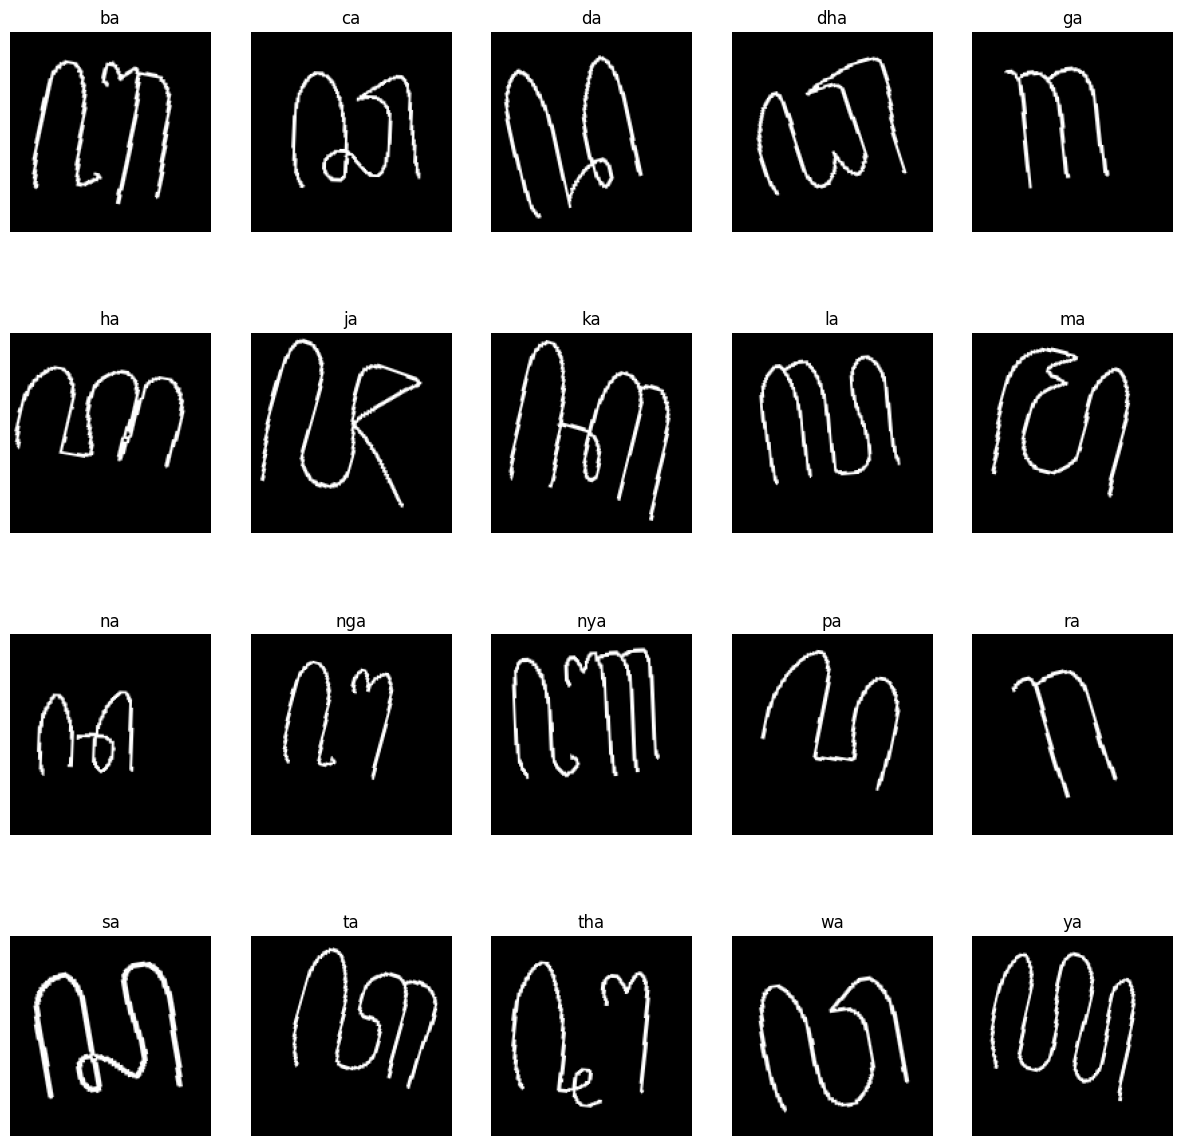

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plt_image

def show_random_images(directory, num_images_per_class=1):
    num_classes = len(os.listdir(directory))
    num_images = num_images_per_class * num_classes
    plt.figure(figsize=(15, 15))
    
    # Iterate over each class directory
    class_directories = os.listdir(directory)
    for i, class_dir in enumerate(class_directories):
        class_path = os.path.join(directory, class_dir)
        class_images = [os.path.join(class_path, name) for name in os.listdir(class_path)]
        
        # Randomly select num_images_per_class images from the current class
        selected_images = np.random.choice(class_images, num_images_per_class, replace=False)
        
        # Display the selected images
        for j, image_path in enumerate(selected_images):
            plt.subplot(4, 5, i*num_images_per_class + j + 1)
            plt.axis('off')
            plt.title(class_dir)
            img = plt_image.imread(image_path)
            plt.imshow(img)

# Panggil fungsi untuk menampilkan gambar
show_random_images(train_dir, num_images_per_class=1)
plt.show()

In [15]:
def count_files(dir):
    arr = []
    for root, dirs, files in os.walk(dir):
        count = 0
        for name in files:
            if name.endswith(".png"):
              count = count + 1
        if count > 0:
          arr.append(count)
    return arr

def get_all_char_names(dir):
    arr = []
    for root, dirs, files in os.walk(dir):
        # print(dirs)
        arr.append(dirs)
        break
    return arr

20
[['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']]


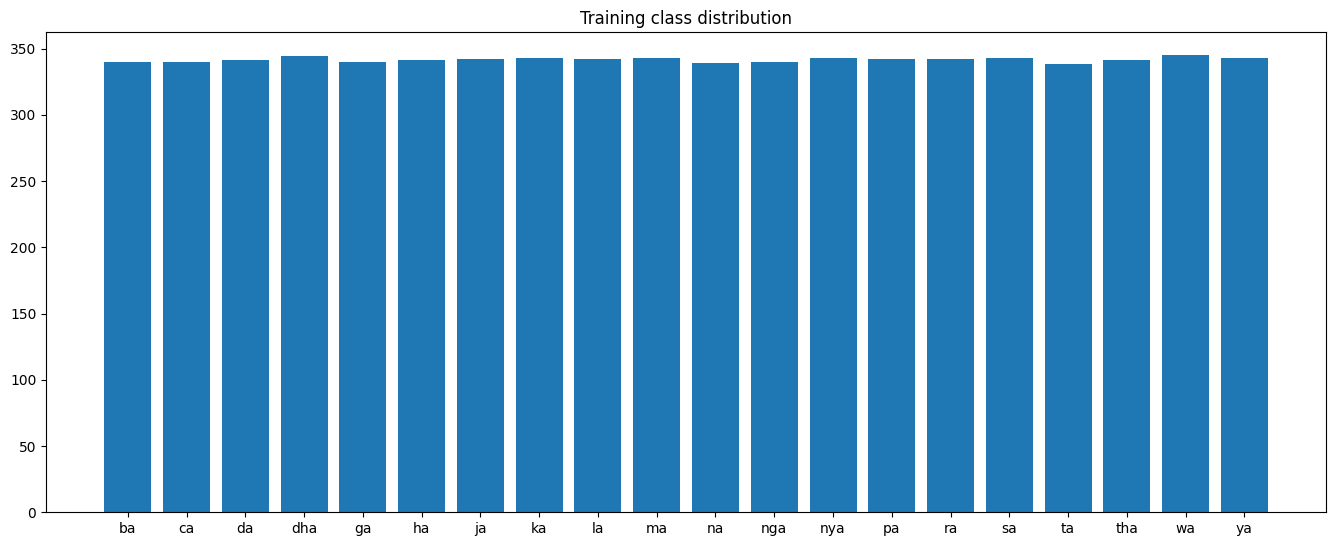

In [16]:
image_count = count_files(train_dir)
print(len(image_count))
chars = get_all_char_names(train_dir)
print(chars)

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(chars[0], image_count)
plt.title("Training class distribution")
plt.show()

In [17]:
# Menghitung jumlah gambar per kelas
file_list = os.listdir(train_dir)

jumlah_gambar_per_kelas = []

for kelas in file_list:
    kelas_path = os.path.join(train_dir, kelas)
    jumlah_gambar = len(os.listdir(kelas_path))
    jumlah_gambar_per_kelas.append(jumlah_gambar)

# Mengecek apakah jumlah data per kelas sudah seimbang
balanced = all(jumlah == jumlah_gambar_per_kelas[0] for jumlah in jumlah_gambar_per_kelas)

# Menampilkan pesan sesuai dengan hasil pemeriksaan
if balanced:
    print("Balanced Data !")
else:
    print("Imbalanced Data !!!\n")
    # Jika imbalanced, tampilkan jumlah data per kelas
    for kelas, jumlah in zip(file_list, jumlah_gambar_per_kelas):
        print(f'Aksara {kelas} jumlah: {jumlah}')

Imbalanced Data !!!

Aksara ba jumlah: 340
Aksara ca jumlah: 340
Aksara da jumlah: 341
Aksara dha jumlah: 344
Aksara ga jumlah: 340
Aksara ha jumlah: 341
Aksara ja jumlah: 342
Aksara ka jumlah: 343
Aksara la jumlah: 342
Aksara ma jumlah: 343
Aksara na jumlah: 339
Aksara nga jumlah: 340
Aksara nya jumlah: 343
Aksara pa jumlah: 342
Aksara ra jumlah: 342
Aksara sa jumlah: 343
Aksara ta jumlah: 338
Aksara tha jumlah: 341
Aksara wa jumlah: 345
Aksara ya jumlah: 343


20
[['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']]


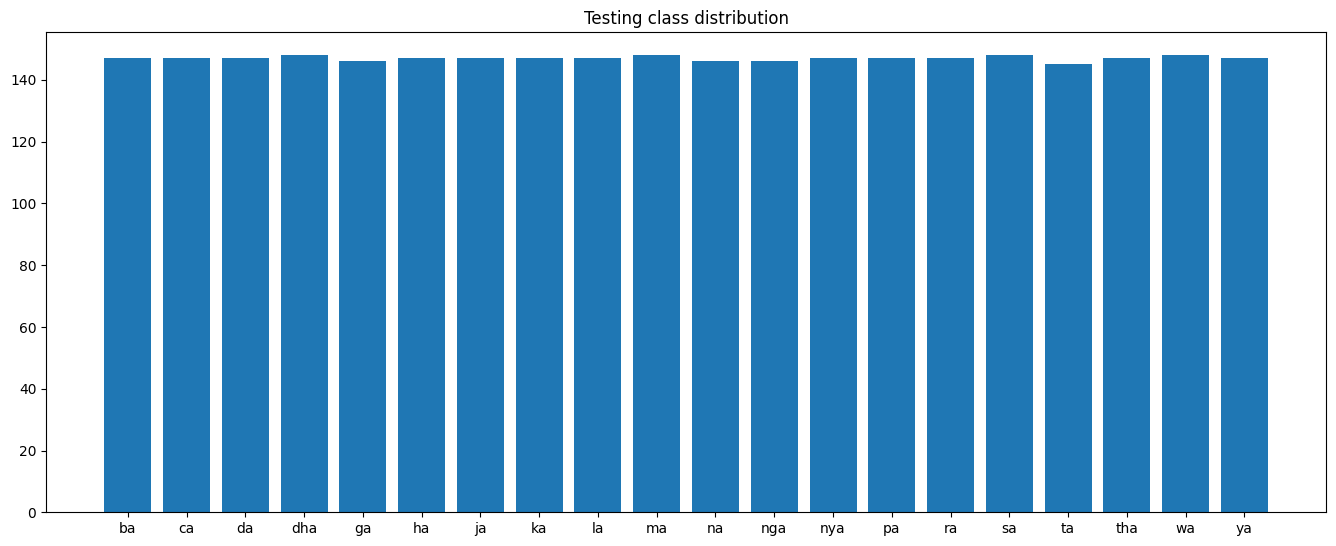

In [18]:
image_count = count_files(test_dir)
print(len(image_count))
chars = get_all_char_names(test_dir)
print(chars)

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(chars[0], image_count)
plt.title("Testing class distribution")
plt.show()

# Build the Model

### Image Data Generator

In [19]:
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Inisialisasi generator data untuk data pelatihan dan validasi
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=Class,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode='grayscale'  # Menentukan mode warna grayscale
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    classes=Class,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode='grayscale'  # Menentukan mode warna grayscale
)

Found 6832 images belonging to 20 classes.
Found 2939 images belonging to 20 classes.


### Model - CNN + VGG

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_vgg16(INPUT_SHAPE=(224, 224, 1), num_classes=NUM_CLASSES):
    model = Sequential()

    # Blok 1
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=INPUT_SHAPE))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Blok 2
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Blok 3
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Blok 4
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Blok 5
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Fully connected layers
    model.add(Flatten(name='flatten'))

    # lapisan Dense 1
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Dropout(0.75))

    # lapisan Dense 2
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Dropout(0.75))

    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create the VGG16 model
model = build_vgg16()

# Adam optimizer with learning rate scheduling and gradient clipping
opt = Adam(learning_rate=0.0001, weight_decay=0.0001, clipvalue=0.5)
    
# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 28, 28, 256)    │         1,02

 Total params: 14,280,436 (54.48 MB)

 Trainable params: 14,273,908 (54.45 MB)

 Non-trainable params: 6,528 (25.50 KB)

### Training Model

In [22]:
# Fungsi untuk menetapkan learning rate secara dinamis
def lr_scheduler(epoch, lr):
    if epoch % 50 == 0 and epoch > 0:
        lr = lr * 0.9  # Mengurangi learning rate setiap 50 epoch
    return lr

lr_schedule = LearningRateScheduler(lr_scheduler)

callbacks_list = [lr_schedule]

In [23]:
# Mencari class weights untuk mengatasi ketidakseimbangan kelas
class_weights = compute_sample_weight('balanced', train_generator.classes)
class_weight = dict(enumerate(class_weights))

# Tentukan jumlah langkah per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = test_generator.samples // BATCH_SIZE

In [25]:
# Lakukan pelatihan model
history = model.fit(
    train_generator,
    epochs=100,  
    # verbose=2,
    callbacks=callbacks_list,  
    validation_data=test_generator,
    class_weight=class_weight,
    steps_per_epoch=None, #steps_per_epoch,
    validation_steps=None #validation_steps
)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 726s 7s/step - accuracy: 0.1702 - loss: 3.9952 - val_accuracy: 0.0500 - val_loss: 4.5130 - learning_rate: 1.0000e-04
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 722s 7s/step - accuracy: 0.4872 - loss: 1.7734 - val_accuracy: 0.0500 - val_loss: 4.9098 - learning_rate: 1.0000e-04
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 723s 7s/step - accuracy: 0.6389 - loss: 1.2023 - val_accuracy: 0.0500 - val_loss: 5.4159 - learning_rate: 1.0000e-04
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 723s 7s/step - accuracy: 0.7017 - loss: 0.9864 - val_accuracy: 0.0728 - val_loss: 4.0393 - learning_rate: 1.0000e-04
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 724s 7s/step - accuracy: 0.7535 - loss: 0.8372 - val_accuracy: 0.2389 - val_loss: 2.5027 - learning_rate: 1.0000e-04
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 721s 7s/step - accuracy: 0.7914 - loss: 0.7362 - val_accuracy: 0.9932 - val_loss: 0.5836 - learning_rate: 1.0000e-04
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 716s 7s/ste

KeyboardInterrupt: 

### Model Graph

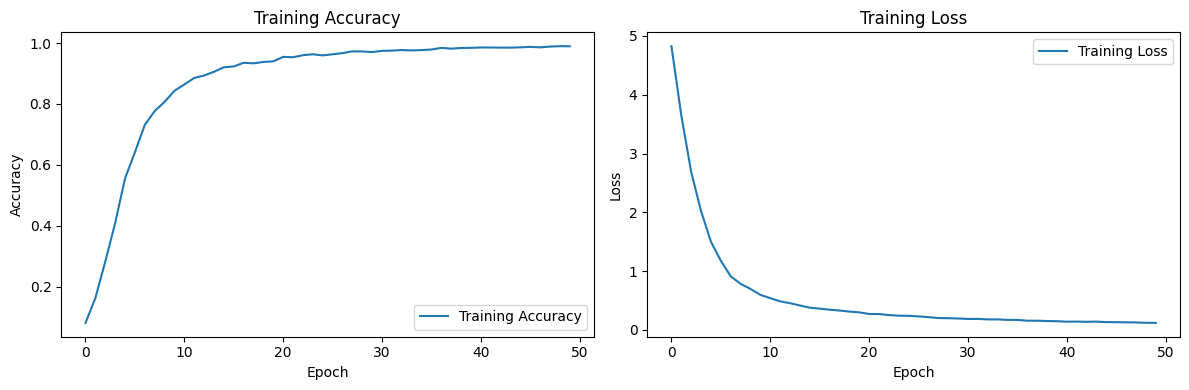

In [21]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

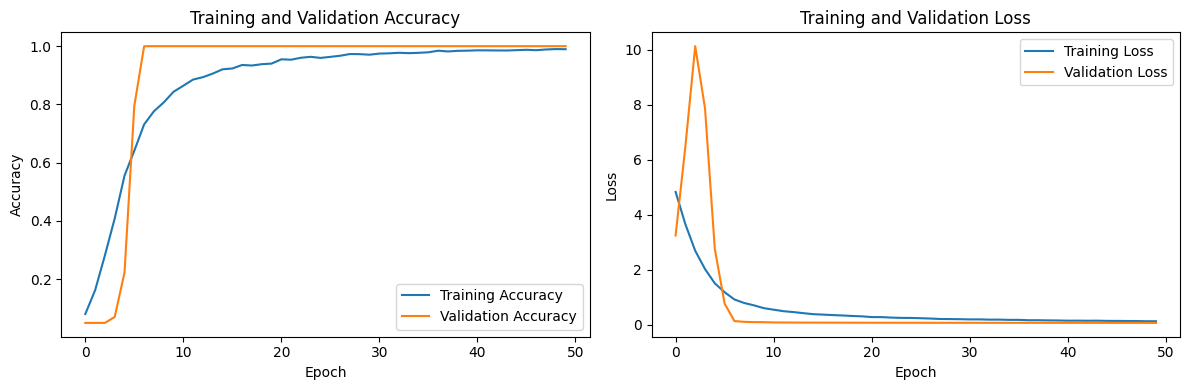

In [22]:
# Menampilkan grafik training dan validation accuracy
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Model Evaluate

In [23]:
# Evaluasi model pada data uji
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 0.0595
Test Accuracy: 100.00%


In [26]:
from keras.models import load_model

# Simpan model ke dalam variabel
# saved_model_path = '../save_models/aksarajawa_v0.0.keras'
saved_model_path = '../save_models/aksarajawa_v0.0.keras'
model.save(saved_model_path)

# Try Predict

In [34]:
# Import the necessary modules
from sklearn import metrics
import math

# Buat generator data untuk data uji
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 3000 images belonging to 20 classes.


In [35]:
# Ganti np.math dengan math
test_steps_per_epoch = math.ceil(test_generator.samples / test_generator.batch_size)

# Gunakan Model.predict alih-alih Model.predict_generator
predictions = model.predict(test_generator, steps=test_steps_per_epoch)

# Dapatkan kelas yang paling mungkin
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

 1/47 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step

c:\Users\M S I\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step


In [36]:
# Lakukan import untuk metrics
from sklearn import metrics

# Hitung dan tampilkan classification report
report = metrics.classification_report(true_classes,
                                       predicted_classes,
                                       target_names = class_labels)
print(report)

              precision    recall  f1-score   support

          ba       1.00      1.00      1.00       150
          ca       1.00      1.00      1.00       150
          da       1.00      1.00      1.00       150
         dha       1.00      1.00      1.00       150
          ga       1.00      1.00      1.00       150
          ha       1.00      1.00      1.00       150
          ja       1.00      1.00      1.00       150
          ka       1.00      1.00      1.00       150
          la       1.00      1.00      1.00       150
          ma       1.00      1.00      1.00       150
          na       1.00      1.00      1.00       150
         nga       1.00      1.00      1.00       150
         nya       1.00      1.00      1.00       150
          pa       1.00      1.00      1.00       150
          ra       1.00      1.00      1.00       150
          sa       1.00      1.00      1.00       150
          ta       1.00      1.00      1.00       150
         tha       1.00    

In [37]:
# Hitung dan tampilkan confusion matrix
confusion_matrix = metrics.confusion_matrix(true_classes, predicted_classes)
print(confusion_matrix)

[[150   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0 150   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0 150   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0 150   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0 150   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0 150   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0 150   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0 150   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0 150   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0 150   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0 150   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 150   0   0   0   0

<Axes: >

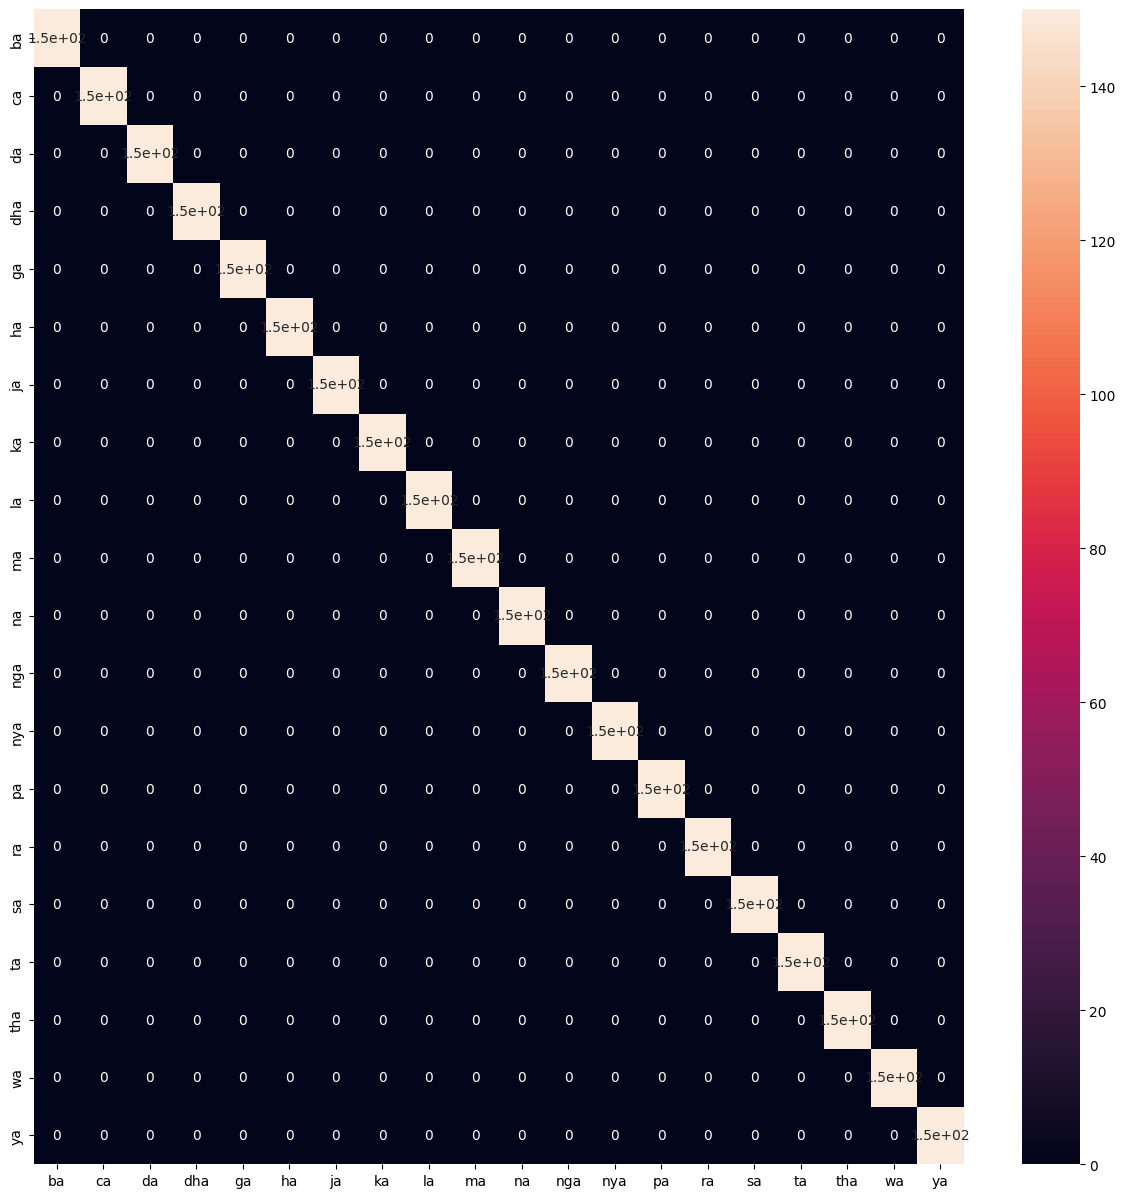

In [38]:
import pandas as pd
import seaborn as sn

# Buat DataFrame untuk confusion matrix
df_cm = pd.DataFrame(confusion_matrix,
                     index=[i for i in ("ba", "ca", "da", "dha", "ga", "ha", "ja", "ka", "la", "ma",
                                        "na", "nga", "nya", "pa", "ra", "sa", "ta", "tha", "wa", "ya")],

                     columns=[i for i in ("ba", "ca", "da", "dha", "ga", "ha", "ja", "ka", "la", "ma",
                                          "na", "nga", "nya", "pa", "ra", "sa", "ta", "tha", "wa", "ya")])
# Tampilkan heatmap
plt.figure(figsize=(15, 15))
sn.heatmap(df_cm, annot=True)

# Try Test

In [ ]:
# loaded_model.summary()

In [ ]:
# from keras.preprocessing import image
# import numpy as np

# # Muat model kembali dari variabel
# loaded_model = load_model(saved_model_path)

# # Load the grayscale image
# test_image_path1 = '../data/data_original/javaneseScript_byPhiard/prediction/ba17.png'
# img = image.load_img(test_image_path1, color_mode='grayscale', target_size=(150, 150))

# # Convert the image to array
# img_array = image.img_to_array(img)

# # Expand the dimensions to match the input shape of the model
# img_array = np.expand_dims(img_array, axis=0)

# # Perform the prediction
# predictions = model.predict(img_array)

# # Get the predicted class index
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Muat model kembali dari variabel
# loaded_model = load_model(saved_model_path)

# # Menguji Model
# test_image_path1 = '../data/data_original/javaneseScript_byPhiard/prediction/ba17.png'
# img = image.load_img(test_image_path1, target_size=(64, 64))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path1)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# # predictions = loaded_model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path2 = '../data/databyPhiard_original/prediction/ba49.mine2.png'
# img = image.load_img(test_image_path2, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path2)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path3 = '../data/databyPhiard_original/prediction/ca2.png'
# img = image.load_img(test_image_path3, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path3)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path4 = '../data/databyPhiard_original/prediction/da5.png'
# img = image.load_img(test_image_path4, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path4)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path5 = '../data/databyPhiard_original/prediction/dha11.png'
# img = image.load_img(test_image_path5, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path5)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path6 = '../data/databyPhiard_original/prediction/ga16.png'
# img = image.load_img(test_image_path6, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path6)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path7 = '../data/databyPhiard_original/prediction/ha0.png'
# img = image.load_img(test_image_path7, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path7)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path8 = '../data/databyPhiard_original/prediction/ja12.png'
# img = image.load_img(test_image_path8, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path8)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path9 = '../data/databyPhiard_original/prediction/ka4.png'
# img = image.load_img(test_image_path9, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path9)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path10 = '../data/databyPhiard_original/prediction/la9.png'
# img = image.load_img(test_image_path10, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path10)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path11 = '../data/databyPhiard_original/prediction/ma.0.jpg'
# img = image.load_img(test_image_path11, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path11)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path12 = '../data/databyPhiard_original/prediction/ma.1.jpg'
# img = image.load_img(test_image_path12, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path12)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path13 = '../data/databyPhiard_original/prediction/ma15.png'
# img = image.load_img(test_image_path13, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path13)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path14 = '../data/databyPhiard_original/prediction/na1.png'
# img = image.load_img(test_image_path14, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path14)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path15 = '../data/databyPhiard_original/prediction/nga19.png'
# img = image.load_img(test_image_path15, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path15)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path16 = '../data/databyPhiard_original/prediction/nga220.pred.png'
# img = image.load_img(test_image_path16, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path16)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path17 = '../data/databyPhiard_original/prediction/nya14.png'
# img = image.load_img(test_image_path17, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path17)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path18 = '../data/databyPhiard_original/prediction/pa10.png'
# img = image.load_img(test_image_path18, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path18)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path19 = '../data/databyPhiard_original/prediction/ra164.pred.png'
# img = image.load_img(test_image_path19, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path19)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path20 = '../data/databyPhiard_original/prediction/ra3.png'
# img = image.load_img(test_image_path20, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path20)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path21 = '../data/databyPhiard_original/prediction/sa7.png'
# img = image.load_img(test_image_path21, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path21)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path22 = '../data/databyPhiard_original/prediction/ta6.png'
# img = image.load_img(test_image_path22, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path22)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path23 = '../data/databyPhiard_original/prediction/tha18.png'
# img = image.load_img(test_image_path23, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path23)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path24 = '../data/databyPhiard_original/prediction/wa8.png'
# img = image.load_img(test_image_path24, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path24)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path25 = '../data/databyPhiard_original/prediction/ya13.png'
# img = image.load_img(test_image_path25, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path25)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path26 = '../data/databyPhiard_original/prediction/nya_01.png'
# img = image.load_img(test_image_path26, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path26)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path26 = '../data/databyPhiard_original/prediction/sa_01.png'
# img = image.load_img(test_image_path26, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path26)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path26 = '../data/databyPhiard_original/prediction/ha201.png'
# img = image.load_img(test_image_path26, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path26)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)